# Feature Creation for UA/UAA Dataset

The notebook will create the features used for the machine learning model. 

We will calculate four technical indicators (simple moving average, exponentially weighted moving average, money flow indices, and relative strength index) for each of the instruments UA and UAA. 

We will then find the spread between each of the percent change between these features for UA and UAA, as well as the spread between the price between each instrument. 

These spreads will be modelled with the Ornstein Uhlenbeck stochastic model. 

The residuals obtained from the stochastic model will then be calculated to a t-score. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit

import pickle

from OU import OU

%load_ext autoreload
%autoreload 2

In [4]:
df_ua = pd.read_csv('./data/df_ua.csv')
df_uaa = pd.read_csv('./data/df_uaa.csv')

# Creating Trading Signals

In this section, we will generate some trading signals that we will feed in as features to our SVM classifier. All of these features of our instruments are based on almost the same fundamentals, thus should very similar if not identical. The trading signals are as follows: 

## Simple Moving Average

$$SMA_{t} = \sum_{i=t-length+1}^{t}Price_{i}$$

The length parameter needs to be tuned based on how near term we want to profit after performing a trade in minutes. This parameter gives us historical temporal relationships within the current price. 

In [5]:
def sma(prices, window):
    """
    Return the Simple Moving Average of the Prices
    
    :prices: pandas Series containing the prices of the ticker
    :window: window size
    
    :ret: Moving average of prices
    """
    return prices.rolling(window).mean()[window:]

## Exponential Weighted Moving Average

$$WMA_{t} = \sum_{i=t-length+1}^{t}Weight_{i}Price_{i}$$

$$Weight_{i} = \frac{i-(t-length)}{\sum_{j=t-length+1}^{t}j-(t-length)}$$

Weighted moving average works the same way as the simple moving average, but it weighs more recent information heavier. 

In [6]:
def ewma(prices, window):
    """
    Return the Weighted Moving Average of the Prices
    
    :prices: pandas Series containing the prices of the ticker
    :window: window size
    
    :ret: Moving average of prices
    """                      
    return pd.Series.ewm(prices, span=window).mean()[window:]

## Money Flow Index

$$MFI_t = 100 - (\frac{100}{1+Money Flow Ratio_t})$$

$$Money Flow Ratio_t = \frac{length - Period Positive Money Flow_{i}}{length - Period Negative Money Flow_{i}}$$

$$MoneyFlow_{t} = volume * \frac{P_{high} + P_{low} + P_{close}}{3}$$

Where Money Flow is positive if:

$$\frac{P_{high}(t) + P_{low}(t) + P_{close}(t)}{3} > \frac{P_{high}(t-1) + P_{low}(t-1) + P_{close}(t-1)}{3}$$

This feature is useful because it incorporates information about volume.

In [7]:
def mfi(df, window):
    """
    Calculates money flow and money flow indices. 
    
    :df: ticker dataframe
    :window: window size
    
    :ret: money flow indices of each point
    """    
    mf = (df['high'] + df['low'] + df['close']) / 3
    i = 0
    pos_mf = [0]
    neg_mf = [0]
    
    # Find Positive Money Flows and Negative Money Flows
    while i < df.index[-1]:
        if mf[i + 1] > mf[i]:
            pos_mf.append(mf[i + 1] * df.loc[i + 1, 'volume'])
            neg_mf.append(0)
        else:
            pos_mf.append(0)
            neg_mf.append(mf[i + 1] * df.loc[i + 1, 'volume'])
        i = i + 1
        
    pos_mf = pd.Series(pos_mf)
    neg_mf = pd.Series(neg_mf)
    
    # Apply a cumulative sum over every window
    pos_sum = pd.Series(pos_mf.rolling(window).sum())
    neg_sum = pd.Series(neg_mf.rolling(window).sum())
    
    mfr = (window - pos_sum)/(window-neg_sum)
    mfi = abs(100 - (100 / (1+mfr)))
    
    return mfi[window:]

## Relative Strength Index

$$RSI_{t} = 100 - (\frac{100}{1+RS_{t}})$$

$$RS_{t} = \frac{avg(length-period up closes)}{avg(length-period down closes)}$$

RSI  is  good  at  indicating  whether  the  stock  is  in  over-
sought or overbought condition.


In [8]:
def rsi(df, window):
    """
    Calculate Relative strength index. First we identify positive and negative closing periods, 
    and then sum over them separately. Then we find the ratio
    
    :df:         Ticker dataframe.
    :window:     Window size. 
    
    :ret: Series of RSIs.
    """
    i = 0
    pos_period = [0]
    neg_period = [0]
    
    # Identify positive and negative closing periods
    while i < df.index[-1]:
        if df.at[i+1, 'close'] > df.at[i, 'close']:
            pos_period.append(df.at[i+1, 'close'])
            neg_period.append(0)
        else:
            pos_period.append(0)
            neg_period.append(df.at[i, 'close'])
        i = i + 1
        
    pos_period = pd.Series(pos_period)
    neg_period = pd.Series(neg_period)
    
    # Apply rolling sum over all of our windows
    pos_sum = pd.Series(pos_period.rolling(window).sum())
    neg_sum = pd.Series(neg_period.rolling(window).sum())
    
    # Normalize with window length to ensure that we don't have 0 in the denominator
    rs = (window - pos_sum)/(window-neg_sum)
    rsi = abs(100 - (100 / (1+rs)))
    
    return rsi[window:]

## Ornstein Uhlenbeck Process to model Residual Terms

The canonical pairs trading model is as follows:

$$\frac{dA_t}{A_t} = \alpha dt + \beta\frac{dB_t}{B_t} + dX_t$$

where $A_t$ is the price of security $A$ at time $t$, $B_t$ is the price of security $B$ at time $t$,
$X_t$ is the residual term, which has the mean-reverting property because mean-reverting
spread is the basic assumption of pairs trading and the drift term, $\alpha dt << \beta\frac{dB_t}{B_t}$, which is neglectable compared to the return of either security.  

The above model shows that
the stock price of the two securities is linear related. The $\beta$ here  helps  solve  the  normalization  problem  since  the two stock prices may not fluctuate in the same range. Furthermore, $\beta$
may change over time because of change of some intrinsic characteristics of either company or change
of overall stock market regime, however, in this project, we assume $\beta$ is a constant term over the duration of the dataset.

In this project, we will use ‘close’ - ‘open’ as $dB_t$ and 'open' as $B_t$. Same applies for $dA_t$ and $A_t$

We  will  use  Ornstein-Uhlenbeck  process to model the residual term because the O-U process is a
stochastic  process  such  that  the  object  modeled  by  the process  always  drifts  towards  its 
long-term  mean. The residual term, namely the spread, has very similar property according the assumption of pairs trading. The residual term $X_t$ from  the  above  spread  model  satisfies  the
following stochastic differential equation:

(Excerpt from http://cs229.stanford.edu/proj2015/028_report.pdf). 

# Feature Creation

We are going to using a window size of 5 for the calculation of the features that incorporate past context (simple moving average, money flow indices, etc...). The reasoning for this particular number is that we want to capitalize on short term trends while still incorporating important information leading up to the present point in our featureset. 

In [10]:
feature_window = 5

df_ua['sma'] = sma(df_ua['close'], feature_window).pct_change()
df_uaa['sma'] = sma(df_uaa['close'], feature_window).pct_change()

df_ua['ewma'] = ewma(df_ua['close'], feature_window).pct_change()
df_uaa['ewma'] = ewma(df_uaa['close'], feature_window).pct_change()

df_ua['mfi'] = mfi(df_ua, feature_window).pct_change()
df_uaa['mfi'] = mfi(df_uaa, feature_window).pct_change()

df_ua['rsi'] = rsi(df_ua, feature_window).pct_change()
df_uaa['rsi'] = rsi(df_uaa, feature_window).pct_change()

df_ua['price'] = df_ua['close'].pct_change()
df_uaa['price'] = df_uaa['close'].pct_change()

# Remove NaNs from rolling features (sma, mfi, rsi...) from dataset. 
df_ua_processed = df_ua[feature_window+1:].reset_index(drop=True)
df_uaa_processed = df_uaa[feature_window+1:].reset_index(drop=True)

In [11]:
df_ua_processed.to_csv('./data/df_ua_processed.csv')
df_uaa_processed.to_csv('./data/df_uaa_processed.csv')

We need to label our dataset into two categories for binary classification. A label value of 1 means that there is a residual shift within the next 5 minutes that we can capitalize on. A label of 0 means that there does not exist such an opportunity in the next 5 minutes and that we should wait. 

In [32]:
def create_label_func(threshold=0.001, window=5):
    """
    Given the spreads of residuals between our pair, label as 1 if the spread change exceeds 
    the threshold, and 0 otherwise. 
    
    :residuals: spreads between the residuals of the pair
    :window: how far in the future in minutes we want to evaluate our position on
    :threshold: the percent change threshold that determines whether a trade is profitable or not. 
    
    :ret: list of labels of 1 or -1.
    """
    def create_labels(residuals):
        if residuals.shape[0] < window:
            return pd.Series(0, index=residuals.index)
        min_val = residuals[::-1].rolling(window=window).min()[::-1]
        min_val.iloc[-window:] = residuals.iloc[-window:]

        a = (residuals-min_val) > threshold
        labels = a.astype(int)
        
        return labels
    
    return create_labels

Read the documentation of the OU class to gain a better idea of what is happening in this step. 

### Window Size
We will use a window size of 5 for label creation. This window size determines how long we will potentially hold a position for before offloading it. We want to profit in the near future before our patience goes out. 

### Threshold
This threshold determines how much of a shift of the price residual constitutes a positive label. This should be set so that the dataset is as close to balanced in the classes as possible in order to improve the SVM for learning purposes. 

In [33]:
# Set Label definition Hyperparameters. 

threshold=0.0005
window=5

label_func = create_label_func(threshold=threshold, window=window)

In [34]:
# Calculates parameters according to mean-reverting OU model. 
OU_transform = OU(df_ua_processed, df_uaa_processed)

This part determines how much information we want our model to incorporate as well as how often we should recalculate our model to incorporate current events. 

Example split_sliding(m_size=30000, e_size=10000)

TRAIN: [0:30000] TEST: [30000:40000]

TRAIN: [10000:40000] TEST: [40000:50000]

TRAIN: [20000:50000] TEST: [50000:60000]

TRAIN: [30000:60000] TEST: [60000:70000]

TRAIN: [40000:70000] TEST: [70000:80000]


:model_size:    How large of training model we want to use for sliding window cross-validation. 
                This parameter will be None if expanding window flag is set. 
:eval_size:     How large of a testing model we want our sliding window cross-validation fit will 
                be evaluated on. 
                This parameter will be none if expanding window flag is set. 

In [35]:
OU_transform.split_slide(m_size=2000, e_size=100)

Sliding Window Split Successful.


In [36]:
# Generates train-test folds and then scales the resulting t-score data between [0-1]
info = OU_transform.get_splits(['price', 'sma', 'ewma', 'mfi', 'rsi'], label_func=label_func, scale=True)

In [37]:
save_dir = "./data/info.npy"

np.save(save_dir, info)

With this threshold and window size, approximately 1/3 of the dataset has a positive label (indicating that we should trade to capture profit from a shift in residuals) and 2/3 of the data has a negative label (indicating that we should do nothing). 

In [38]:
labels = np.hstack(np.array([fold['test']['labels'] for fold in info]))
np.bincount(labels)

/Users/xijiaqi/opt/anaconda3/envs/hft/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([14881, 24921])

Inspection of each individual fold for the threshold and its residuals. 

In [39]:
plot = True

In [ ]:
if plot: 
    for fold, thing in enumerate(info):
        train = thing['train']
        test = thing['test']

        train_residuals = train['residuals_fit_price']
        test_residuals = test['residuals_transform_price']
        window=5

        min_val_train = train_residuals[::-1].rolling(window=window).min()[::-1]
        min_val_test = test_residuals[::-1].rolling(window=window).min()[::-1]

        fig = plt.figure(figsize=(8, 6))
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2, sharey=ax1)


        ax1.boxplot((train_residuals - min_val_train)[:-window])
        ax1.set_title('TRAIN')
        ax1.axhline(threshold, linestyle='dashed', color='black', alpha=0.7)
        ax1.grid()

        ax2.boxplot((test_residuals - min_val_test)[:-window])
        ax2.set_title('TEST')

        ax2.grid()
        ax2.axhline(threshold, linestyle='dashed', color='black', alpha=0.7)

        plt.suptitle('Fold %d' % fold)
        plt.savefig("./plots/residual_plots/fold_residual_%i" % fold)
        plt.close(fig)

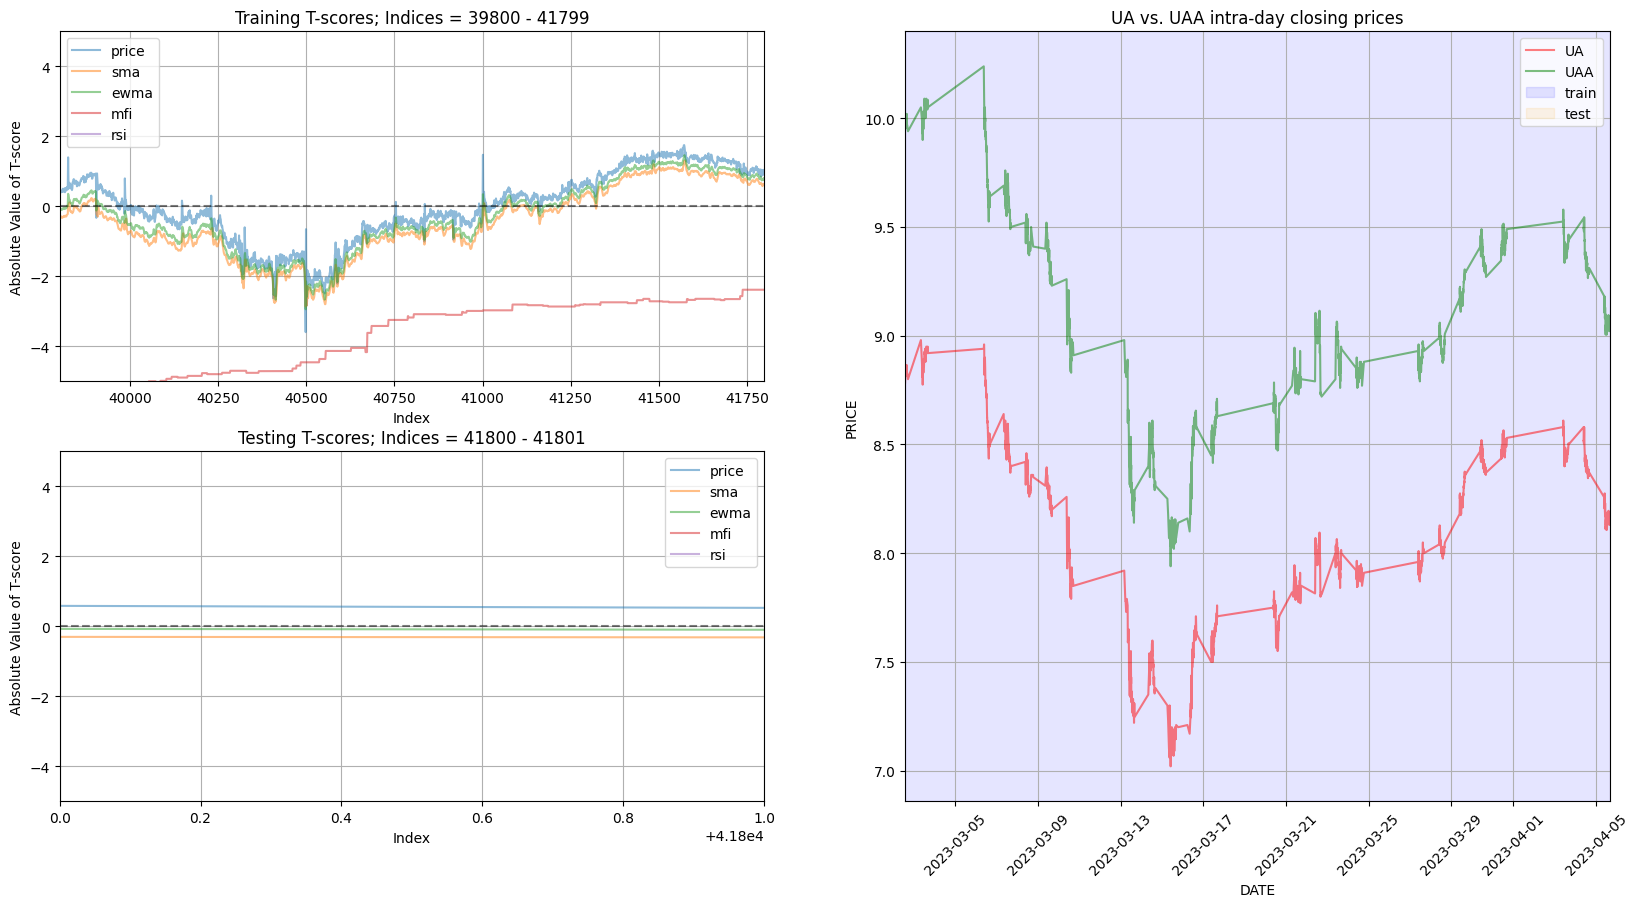

In [40]:
img_directory = './plots/fold_plots/'
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter

if plot:
    df_ua.TIMESTAMP = pd.to_datetime(df_ua.TIMESTAMP)
    df_uaa.TIMESTAMP = pd.to_datetime(df_uaa.TIMESTAMP)
    
    for fold in range(len(info)):
        train = info[fold]['train']['df']
        test = info[fold]['test']['df']

        df_view = df_ua.iloc[train.index[0]:test.index[-1]]
        df_viewl = df_uaa.iloc[train.index[0]:test.index[-1]]

        fig = plt.figure(figsize=(20, 10))
        gridspec.GridSpec(2, 2)

        ax1 = plt.subplot2grid((2, 2), (0, 0))
        train.plot(ax=ax1, alpha=0.5)
        ax1.legend()
        ax1.set_title('Training T-scores; Indices = %d - %d' % (train.index[0], train.index[-1]))
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Absolute Value of T-score')
        ax1.set_ylim([-5, 5])
        ax1.set_xlim([train.index[0], train.index[-1]])
        ax1.axhline(0, linestyle='dashed', alpha=0.5, color='black')
        ax1.grid()

        ax2 = plt.subplot2grid((2, 2), (1, 0))
        test.plot(ax=ax2, alpha=0.5)
        ax2.legend()
        ax2.set_title('Testing T-scores; Indices = %d - %d' % (test.index[0], test.index[-1]))
        ax2.set_xlabel('Index')
        ax2.set_ylabel('Absolute Value of T-score')
        ax2.set_ylim([-5, 5])
        ax2.set_xlim([test.index[0], test.index[-1]])
        ax2.axhline(0, linestyle='dashed', alpha=0.5, color='black')
        ax2.grid()

        ax3 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
        ax3.plot(df_view["TIMESTAMP"], df_view["close"], color='red', alpha=0.5, label='UA',)
        ax3.plot(df_viewl["TIMESTAMP"], df_viewl["close"], color='green', alpha=0.5, label='UAA')
        ax3.set_title('UA vs. UAA intra-day closing prices')
        ax3.set_xlabel('DATE')
        ax3.set_ylabel('PRICE')
        ax3.axvspan(df_view.loc[train.index[0]].TIMESTAMP, df_view.loc[train.index[-1]].TIMESTAMP, color='blue', alpha=0.1, label='train')
        ax3.axvspan(df_view.loc[train.index[-1]].TIMESTAMP, df_view.loc[test.index[-2]].TIMESTAMP, color='orange', alpha=0.1, label='test')
        ax3.set_xlim([df_view.loc[train.index[0]].TIMESTAMP, df_view.loc[test.index[-2]].TIMESTAMP])
        ax3.grid()
        ax3.legend()
        plt.xticks(rotation=45)
        plt.savefig(img_directory+'fold%d' % fold)